In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 為了處理方便，把 'train.csv' 和 'test.csv' 合併起來，'test.csv'的 Weather 欄位用 0 補起來。
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_test['Weather'] = np.zeros((len(df_test)))

# 以 train_end_idx 作為 'train.csv' 和 'test.csv' 分界列，
train_end_idx = len(df)
df = pd.concat([df, df_test], sort=False, ignore_index=True)

In [3]:
if 'Date' in df.columns:
    # df['Year'] = pd.to_datetime(df['Date']).dt.year
    # df['Month'] = pd.to_datetime(df['Date']).dt.month
    # df['Day'] = pd.to_datetime(df['Date']).dt.day
    df['Week'] = pd.to_datetime(df['Date']).dt.week

/tmp/ipykernel_36084/3945439383.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['Week'] = pd.to_datetime(df['Date']).dt.week


<AxesSubplot: >

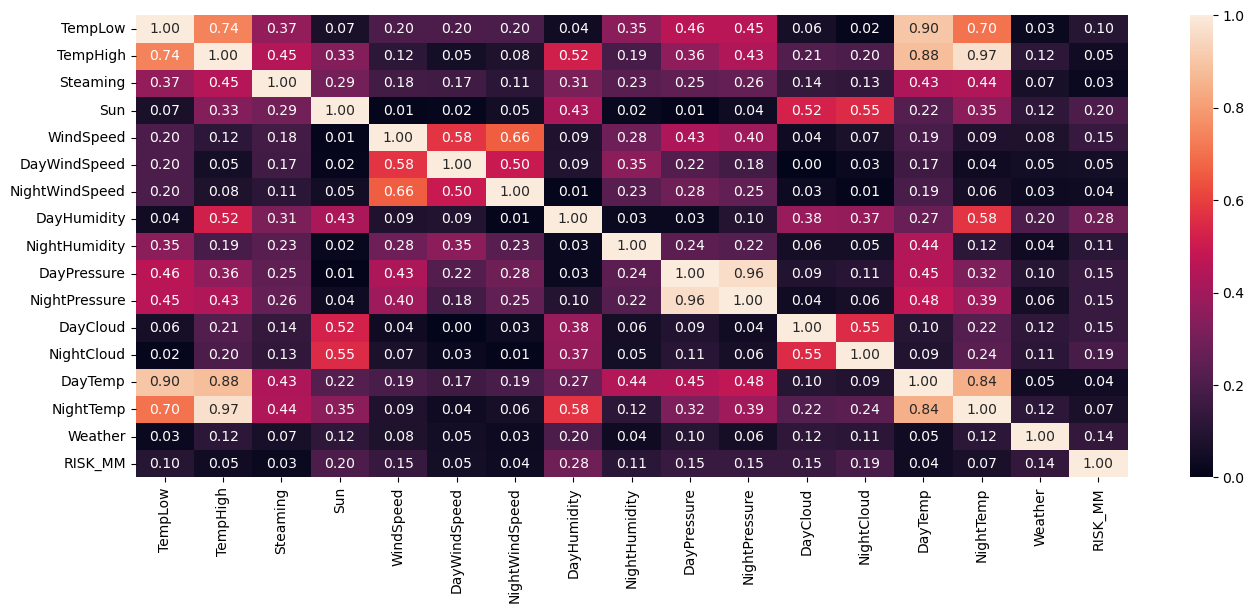

In [4]:
import seaborn as sns
plt.figure(figsize=(16, 6))
sns.heatmap(df.corr().abs(), vmin=0, vmax=1, annot=True, fmt=".2f")

In [4]:
from sklearn.impute import SimpleImputer

for col in df.columns:
    if col == 'Weather':
        continue
    if df[col].dtype == float:
        imp = SimpleImputer(strategy='median')
        a = imp.fit_transform(df[col].values.reshape(-1, 1))
        a = pd.Series(a[:,0])
        df[col] = a
    elif df[col].dtype == object:
        imp = SimpleImputer(strategy='most_frequent')
        b = imp.fit_transform(df[col].values.reshape(-1, 1))
        b = pd.Series(b[:, 0])
        df[col] = b

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components='mle')

# print(pca.fit_transform(df[['DayCloud', 'NightCloud']]))
df['Pressure'] = pca.fit_transform(df[['DayPressure', 'NightPressure']])
df.drop(columns=['DayPressure', 'NightPressure'], inplace=True)

print(pca.n_components_)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

1
[0.88456326]
[0.88456326]


In [6]:
pca = PCA(n_components='mle')

# print(pca.fit_transform(df[['DayCloud', 'NightCloud']]))
df['Cloud'] = pca.fit_transform(df[['DayCloud', 'NightCloud']])
df.drop(columns=['DayCloud', 'NightCloud'], inplace=True)

print(pca.n_components_)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

1
[0.72395658]
[0.72395658]


In [7]:
df[['Temp1', 'Temp2']] = pca.fit_transform(df[['TempLow', 'DayTemp', 'TempHigh', 'NightTemp']])
df.drop(columns=['TempLow', 'DayTemp', 'TempHigh', 'NightTemp'], inplace=True)

print(pca.n_components_)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

2
[0.75758029 0.12443441]
[0.75758029 0.8820147 ]


In [8]:
df[['WindSpeed1', 'WindSpeed2']] = pca.fit_transform(df[['WindSpeed', 'DayWindSpeed', 'NightWindSpeed']])
df.drop(columns=['WindSpeed', 'DayWindSpeed', 'NightWindSpeed'], inplace=True)

print(pca.n_components_)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

2
[0.69400192 0.16752112]
[0.69400192 0.86152303]


In [9]:
df[['Humidity1', 'Humidity2']] = pca.fit_transform(df[['Sun', 'DayHumidity', 'NightHumidity']])
df.drop(columns=['Sun', 'DayHumidity', 'NightHumidity'], inplace=True)

print(pca.n_components_)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

2
[0.72273894 0.26286259]
[0.72273894 0.98560154]


<AxesSubplot: >

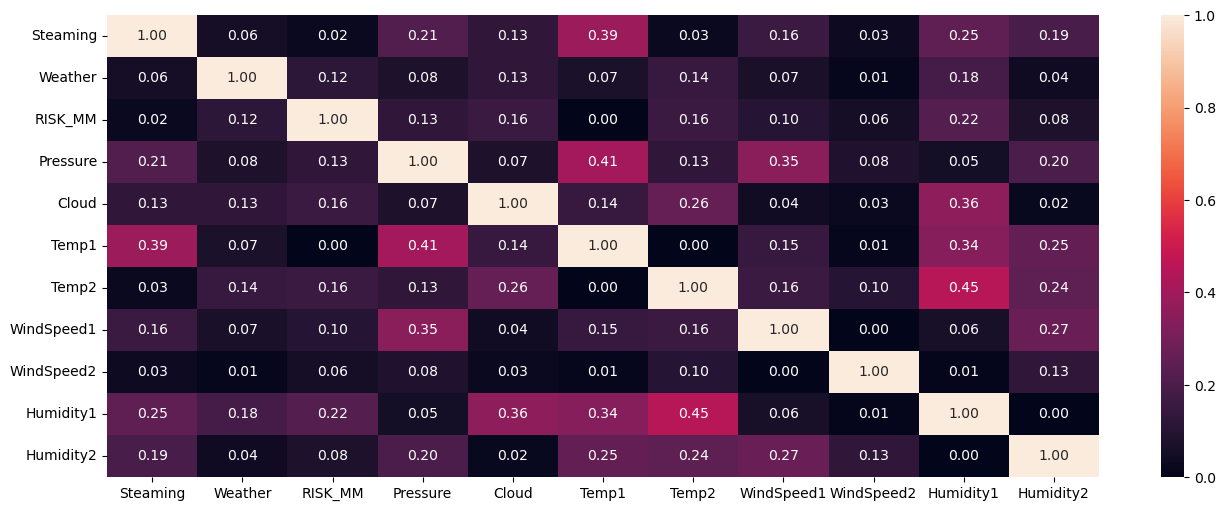

In [11]:
plt.figure(figsize=(16, 6))
sns.heatmap(df.corr().abs(), vmin=0, vmax=1, annot=True, fmt=".2f")

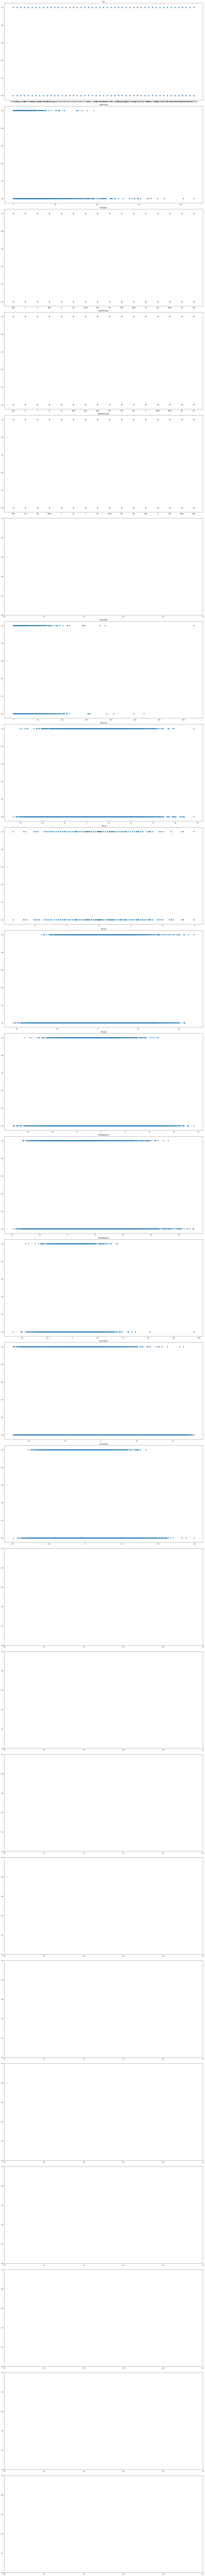

In [12]:
fig, ax = plt.subplots(25)
fig.set_size_inches(20, 250)
for col, idx in zip(df.columns, range(len(df.columns))):
    if col == 'Weather':
        continue
    sub = df[[col, 'Weather']]
    if df[col].dtype == object:
        dropRow = [idx for idx, data in zip(range(len(sub[col])), sub[col]) if type(data) == float]
        sub = sub.drop(dropRow)
    elif df[col].dtype == float:
        dropRow = [idx for idx, data in zip(range(len(sub[col])), sub[col]) if np.isnan(data)]
        sub = sub.drop(dropRow)
    
    ax[idx].scatter(sub[col], sub['Weather'])
    ax[idx].set_title(col)
plt.tight_layout()
plt.show()

In [10]:
# 處理非數值欄位
from sklearn.preprocessing import StandardScaler, LabelEncoder

ohe = []
scaler = StandardScaler()
LE = LabelEncoder()

for col in df.columns:
    if col == 'Weather':
        continue
    if df[col].dtype == object or col in ['Year', 'Month', 'Day', 'Week']:
        print(col, 'object')
        ohe.append(col)
        df[col] = LE.fit_transform(df[col])
    elif df[col].dtype == float:
        print(col, 'float')
        a = scaler.fit_transform(df[col].values.reshape(-1, 1))
        a = pd.Series(a[:, 0])
        df[col] = a

df = pd.get_dummies(df, columns=ohe)


# 將 missing value 補上平均值
# for col in df.columns:


# 將非數值欄位拿掉
# dropCol = [col for col in df.columns if df[col].dtype == np.object]
# df = df.drop(columns = dropCol)

# 將 missing value 補 0
# df = df.fillna(0)

Date object
Loc object
Steaming float
WindDir object
DayWindDir object
NightWindDir object
RISK_MM float
Week object
Pressure float
Cloud float
Temp1 float
Temp2 float
WindSpeed1 float
WindSpeed2 float
Humidity1 float
Humidity2 float


# train

In [11]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_train, X_val, y_train, y_val = train_test_split(
    df.drop(columns = ['Weather']).values[:train_end_idx, :],
    df['Weather'].values[:train_end_idx], test_size=0.5)

X_train, y_train = sm.fit_resample(X_train, y_train)

X_test = df.drop(columns = ['Weather']).values[train_end_idx:, :]

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score

# train model
# model = DecisionTreeClassifier()
# model.fit(X_train,y_train.astype('int'))
# y_pred_decision = model.predict(X_val)
# print('--- Decision Tree ---')
# print('Accuracy: %f' % accuracy_score(y_val.astype('int'), y_pred_decision))
# print('f1-score: %f' % f1_score(y_val.astype('int'), y_pred_decision))

# model = SVC(kernel = 'rbf', C = 2, random_state = 0)
# model.fit(X_train,y_train.astype('int'))
# y_pred_decision = model.predict(X_val)
# print('\n--- SVC: rbf ---')
# print('Accuracy: %f' % accuracy_score(y_val.astype('int'), y_pred_decision))
# print('f1-score: %f' % f1_score(y_val.astype('int'), y_pred_decision))

# model = SVC(kernel = 'linear', C = 2, random_state = 0)
# model.fit(X_train,y_train.astype('int'))
# y_pred_decision = model.predict(X_val)
# print('\n--- SVC: linear ---')
# print('Accuracy: %f' % accuracy_score(y_val.astype('int'), y_pred_decision))
# print('f1-score: %f' % f1_score(y_val.astype('int'), y_pred_decision))

# model = KNeighborsClassifier(n_neighbors = 5, p = 2)
# model.fit(X_train,y_train.astype('int'))
# y_pred_decision = model.predict(X_val)
# print('\n--- K Neighbors ---')
# print('Accuracy: %f' % accuracy_score(y_val.astype('int'), y_pred_decision))
# print('f1-score: %f' % f1_score(y_val.astype('int'), y_pred_decision))

# model = RandomForestClassifier(criterion = 'gini', n_estimators = 10, random_state = 0)
# model.fit(X_train,y_train.astype('int'))
# y_pred_decision = model.predict(X_val)
# print('\n--- Random Forest ---')
# print('Accuracy: %f' % accuracy_score(y_val.astype('int'), y_pred_decision))
# print('f1-score: %f' % f1_score(y_val.astype('int'), y_pred_decision))

# model = AdaBoostClassifier(n_estimators = 100, random_state = 0)
# model.fit(X_train,y_train.astype('int'))
# y_pred_decision = model.predict(X_val)
# print('\n--- Ada Boost ---')
# print('Accuracy: %f' % accuracy_score(y_val.astype('int'), y_pred_decision))
# print('f1-score: %f' % f1_score(y_val.astype('int'), y_pred_decision))

model = GradientBoostingClassifier()
print(X_train, y_train.astype('int'))
model.fit(X_train,y_train.astype('int'))
y_pred_decision = model.predict(X_val)
print(y_pred_decision)
print('\n--- Gradient Boosting ---')
print('Accuracy: %f' % accuracy_score(y_val.astype('int'), y_pred_decision))
print('f1-score: %f' % f1_score(y_val.astype('int'), y_pred_decision))

# predict
# y_pred_decision = model.predict(X_val)
# print('Accuracy: %f' % accuracy_score(y_val.astype('int'), y_pred_decision))
# print('f1-score: %f' % f1_score(y_val.astype('int'), y_pred_decision))

[0 0 0 ... 0 1 0]

--- Gradient Boosting ---
Accuracy: 0.853453
f1-score: 0.398973


In [16]:
ans_pred = model.predict(X_test)
df_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])
df_sap.to_csv('myAns.csv',  index_label = 'Id')